In [129]:
import mne
import os
import re

# load data, I'm using NDARAA396TWZ and NDARAA773LUW as samples
resting_state_path = "sub-NDARAA396TWZ_task-RestingState_eeg.set"
contrast_change_path = "sub-NDARAA773LUW_task-contrastChangeDetection_run-1_eeg.set"

raw_data = []
raw_dir = os.path.join('..', '..', 'raw')
for file_name in [resting_state_path, contrast_change_path]:
    file_path = os.path.join(raw_dir, file_name)
    raw = mne.io.read_raw_eeglab(file_path, preload=True)
    raw_data.append(raw)

resting_state, contrast_change = raw_data
resting_state_sfreq = resting_state.info['sfreq']
contrast_change_sfreq = contrast_change.info['sfreq']

In [130]:
# data preparation
resting_state.filter(l_freq=1.0, h_freq=None)
contrast_change.filter(l_freq=1.0, h_freq=None)

# get first 3 seconds for consistency and ease of testing
resting_state_crop = resting_state.copy().crop(tmin=0, tmax=3)
contrast_change_crop = contrast_change.copy().crop(tmin=0, tmax=3)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1651 samples (3.302 s)
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1651 samples (3.302 s)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass,

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 50 Hz

FIR filter parameters
---------------------
Setting up low-pass filter at 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 133 samples (0.266 s)

- Filter length: 133 samples (0.266 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 50 Hz

FIR filter parameters
---------------------
Designing a o

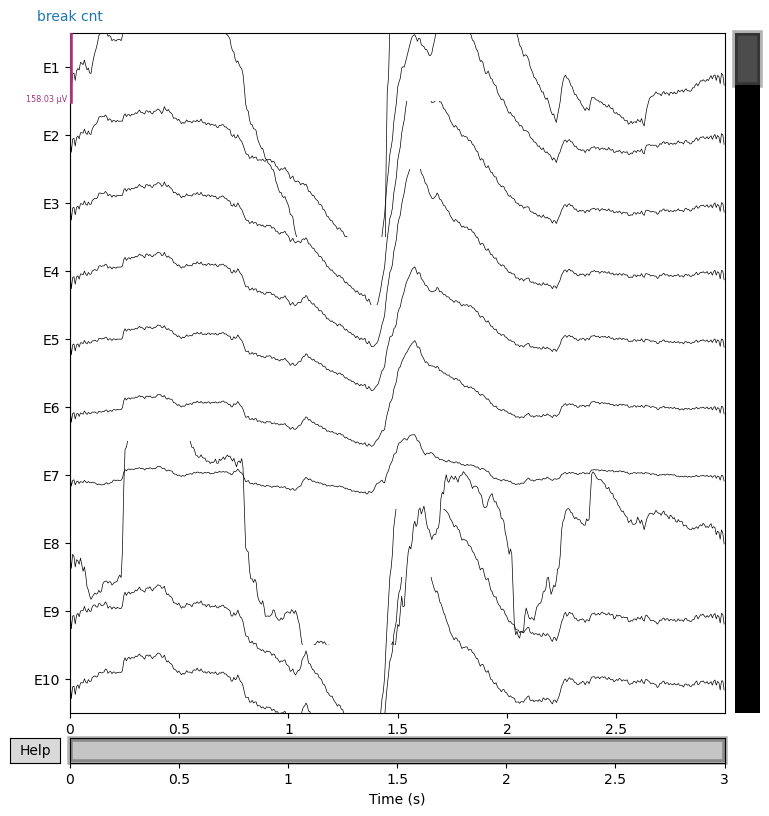

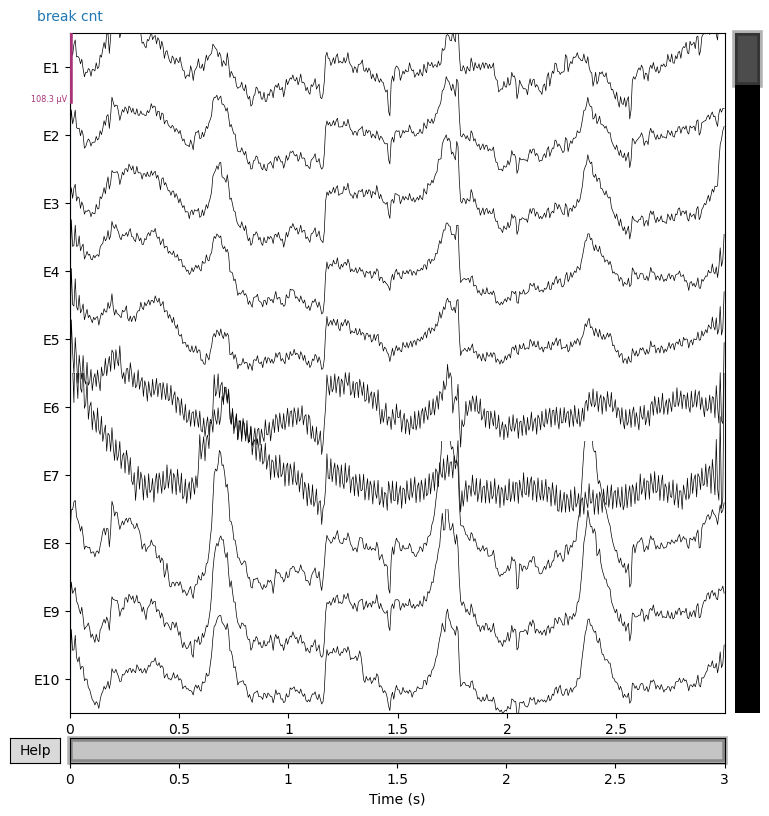

In [131]:
# low pass filter
h_freq = 50.0

low_pass_resting = resting_state_crop.copy().filter(l_freq=None, h_freq=h_freq)
low_pass_contrast = contrast_change_crop.copy().filter(l_freq=None, h_freq=h_freq)

p = low_pass_resting.plot(n_channels=10, scalings='auto', title='Low-pass Filtered Resting State', show=True, block=False)
p = low_pass_contrast.plot(n_channels=10, scalings='auto', title='Low-pass Filtered Contrast Change', show=True, block=False)

c:\Users\JINQI\anaconda3\Lib\site-packages\asrpy\asr_utils.py:124: RuntimeWarning: divide by zero encountered in divide
  cols = nbins / newX[mcurr]
c:\Users\JINQI\anaconda3\Lib\site-packages\asrpy\asr_utils.py:125: RuntimeWarning: invalid value encountered in multiply
  H = newX[:m] * cols


Creating RawArray with float64 data, n_channels=129, n_times=1501
    Range : 0 ... 1500 =      0.000 ...     3.000 secs
Ready.
    Range : 0 ... 1500 =      0.000 ...     3.000 secs
Ready.


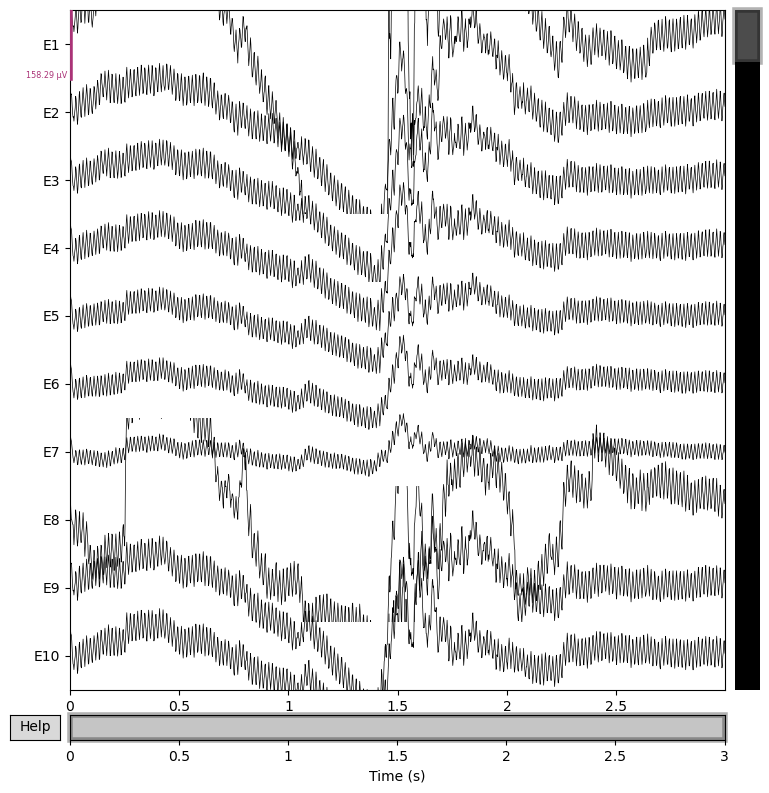

In [132]:
# Artifact Subspace Reconstruction (ASR)
# using ASRpy package
from asrpy import asr_calibrate, asr_process
import numpy as np

M, T = asr_calibrate(
    X=resting_state_crop.get_data().copy(),
    sfreq=resting_state_sfreq,
    cutoff=5
)

# using asr_process
asr_resting = asr_process(
    data=resting_state_crop.get_data().copy(),
    sfreq=resting_state_sfreq,
    M=M,
    T=T,
    lookahead=0.01,
)

asr_resting_raw = mne.io.RawArray(asr_resting, resting_state_crop.info)
asr_resting_raw.info['description'] = 'ASR processed resting state data'

p = asr_resting_raw.plot(n_channels=10, scalings='auto', title='ASR Processed Resting State', show=True, block=False)

c:\Users\JINQI\anaconda3\Lib\site-packages\asrpy\asr_utils.py:124: RuntimeWarning: divide by zero encountered in divide
  cols = nbins / newX[mcurr]
c:\Users\JINQI\anaconda3\Lib\site-packages\asrpy\asr_utils.py:125: RuntimeWarning: invalid value encountered in multiply
  H = newX[:m] * cols


Creating RawArray with float64 data, n_channels=129, n_times=1501
    Range : 0 ... 1500 =      0.000 ...     3.000 secs
Ready.
    Range : 0 ... 1500 =      0.000 ...     3.000 secs
Ready.


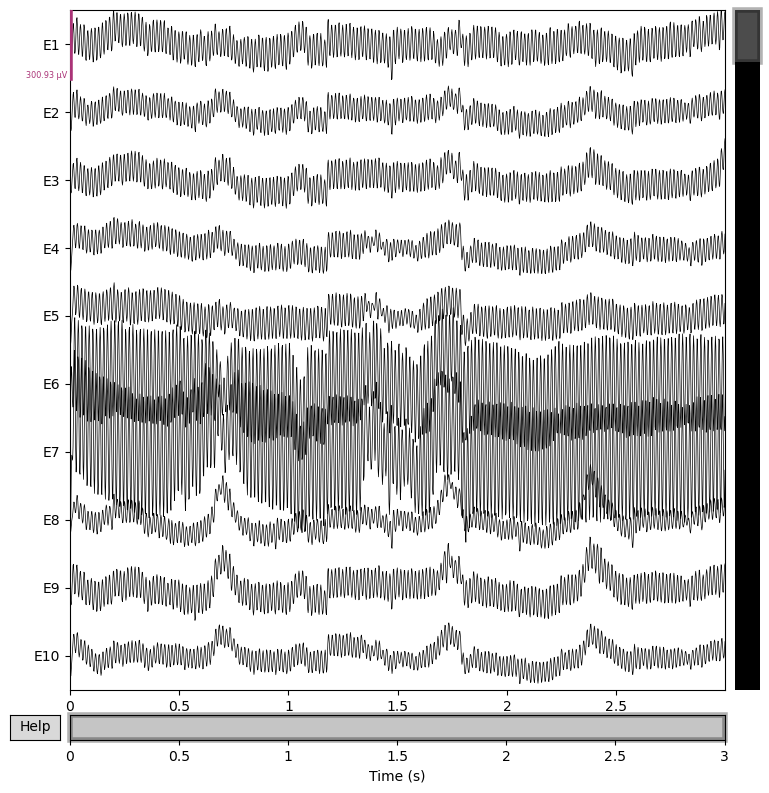

In [133]:
# repeat for contrast change data
M, T = asr_calibrate(
    X=contrast_change_crop.get_data().copy(),
    sfreq=resting_state_sfreq,
    cutoff=5
)

# using asr_process
asr_contrast = asr_process(
    data=contrast_change_crop.get_data().copy(),
    sfreq=resting_state_sfreq,
    M=M,
    T=T,
    lookahead=0.01
)

asr_contrast_raw = mne.io.RawArray(asr_contrast, contrast_change_crop.info)
asr_contrast_raw.info['description'] = 'ASR processed contrast change data'

p = asr_contrast_raw.plot(n_channels=10, scalings='auto', title='ASR Processed Contrast Change', show=True, block=False)

Creating RawArray with float64 data, n_channels=129, n_times=1501
    Range : 0 ... 1500 =      0.000 ...     3.000 secs
Ready.
    Range : 0 ... 1500 =      0.000 ...     3.000 secs
Ready.


c:\Users\JINQI\anaconda3\Lib\site-packages\asrpy\asr_utils.py:124: RuntimeWarning: divide by zero encountered in divide
  cols = nbins / newX[mcurr]
c:\Users\JINQI\anaconda3\Lib\site-packages\asrpy\asr_utils.py:125: RuntimeWarning: invalid value encountered in multiply
  H = newX[:m] * cols
c:\Users\JINQI\anaconda3\Lib\site-packages\asrpy\asr.py:750: RuntimeWarning: invalid value encountered in divide
  wz[ichan] = (Y - mu) / sig


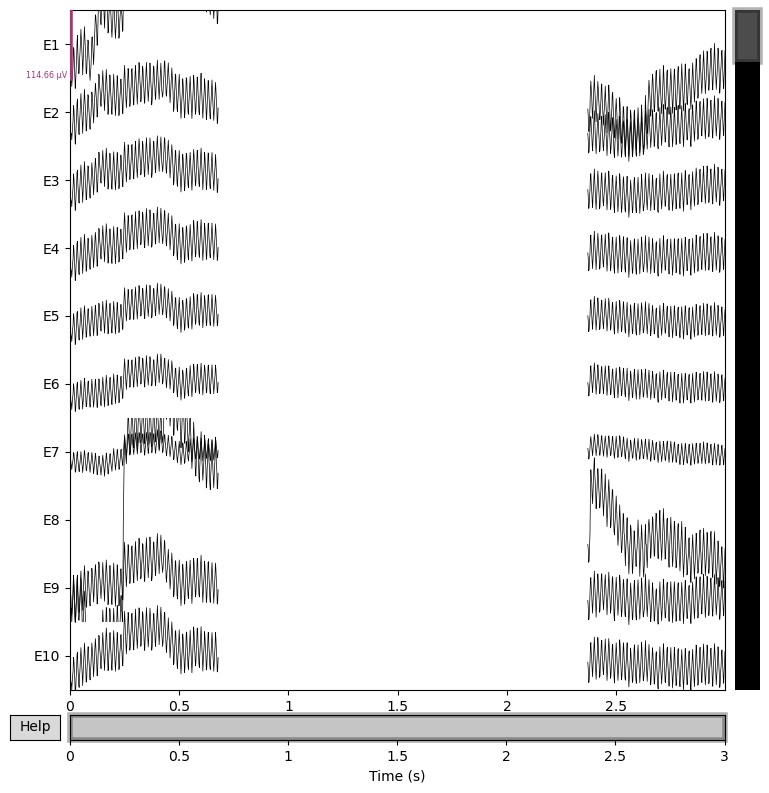

In [134]:
# clean windows (another cool tool asrpy offers)
from asrpy import clean_windows

resting_cleaned, mask = clean_windows(
    X=resting_state_crop.get_data(),
    sfreq=resting_state_sfreq
)

mask = mask.flatten()

resting_full = resting_state_crop.get_data().copy()
resting_full[:, ~mask] = np.nan

resting_cleaned_raw = mne.io.RawArray(resting_full, resting_state_crop.info)
resting_cleaned_raw.info['description'] = 'Cleaned windows resting state data'

p = resting_cleaned_raw.plot(n_channels=10, scalings='auto', title='Cleaned Windows Resting State', show=True, block=False)

Creating RawArray with float64 data, n_channels=129, n_times=1501
    Range : 0 ... 1500 =      0.000 ...     3.000 secs
Ready.
    Range : 0 ... 1500 =      0.000 ...     3.000 secs
Ready.


c:\Users\JINQI\anaconda3\Lib\site-packages\asrpy\asr_utils.py:124: RuntimeWarning: divide by zero encountered in divide
  cols = nbins / newX[mcurr]
c:\Users\JINQI\anaconda3\Lib\site-packages\asrpy\asr_utils.py:125: RuntimeWarning: invalid value encountered in multiply
  H = newX[:m] * cols
c:\Users\JINQI\anaconda3\Lib\site-packages\asrpy\asr.py:750: RuntimeWarning: invalid value encountered in divide
  wz[ichan] = (Y - mu) / sig


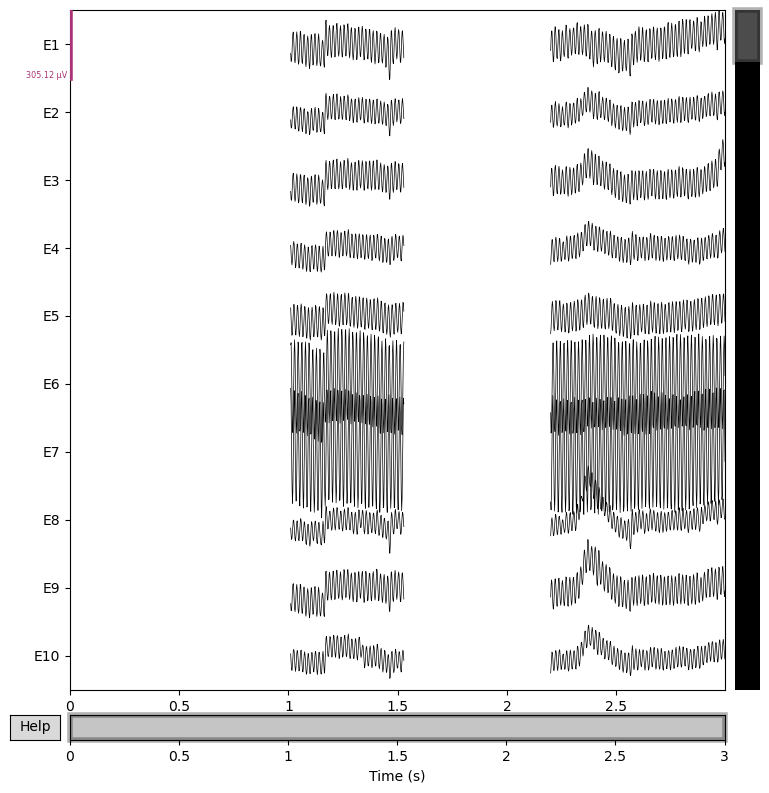

In [135]:
# repeat for contrast change data
contrast_cleaned, mask = clean_windows(
    X=contrast_change_crop.get_data(),
    sfreq=contrast_change_sfreq
)

mask = mask.flatten()

contrast_full = contrast_change_crop.get_data().copy()
contrast_full[:, ~mask] = np.nan

contrast_cleaned_raw = mne.io.RawArray(contrast_full, contrast_change_crop.info)
contrast_cleaned_raw.info['description'] = 'Cleaned windows contrast change data'

p = contrast_cleaned_raw.plot(n_channels=10, scalings='auto', title='Cleaned Windows Contrast Change', show=True, block=False)

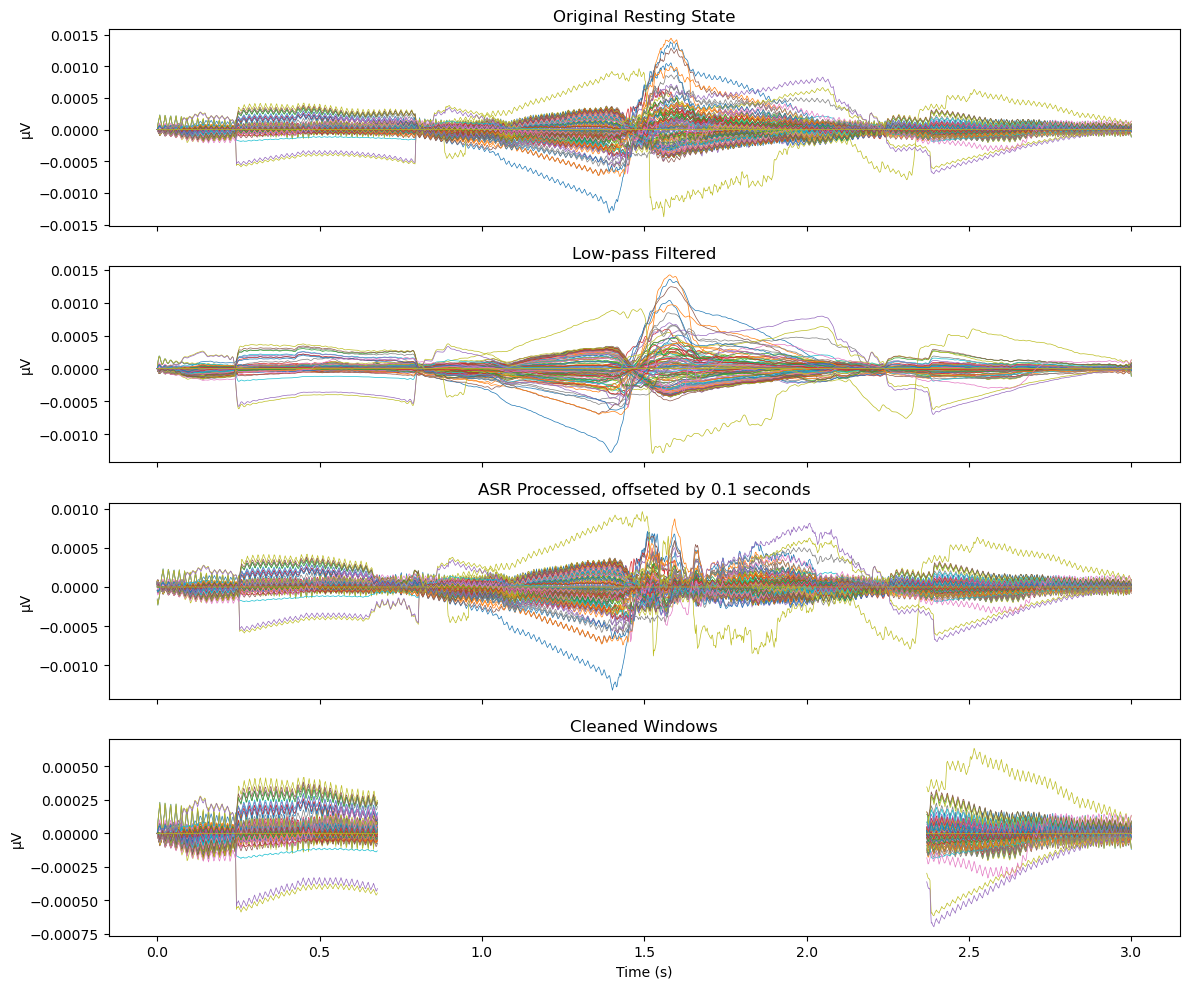

In [136]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

tmin, tmax = 0, 3
for ax, (raw, title) in zip(
    axes,
    [
        (resting_state_crop, "Original Resting State"),
        (low_pass_resting, "Low-pass Filtered"),
        (asr_resting_raw, "ASR Processed, offseted by 0.1 seconds"),
        (resting_cleaned_raw, "Cleaned Windows"),
    ],
):
    data, times = raw.copy().crop(tmin, tmax).get_data(return_times=True)
    ax.plot(times, data.T, lw=0.5)
    ax.set_title(title)
    ax.set_ylabel("µV")

axes[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()

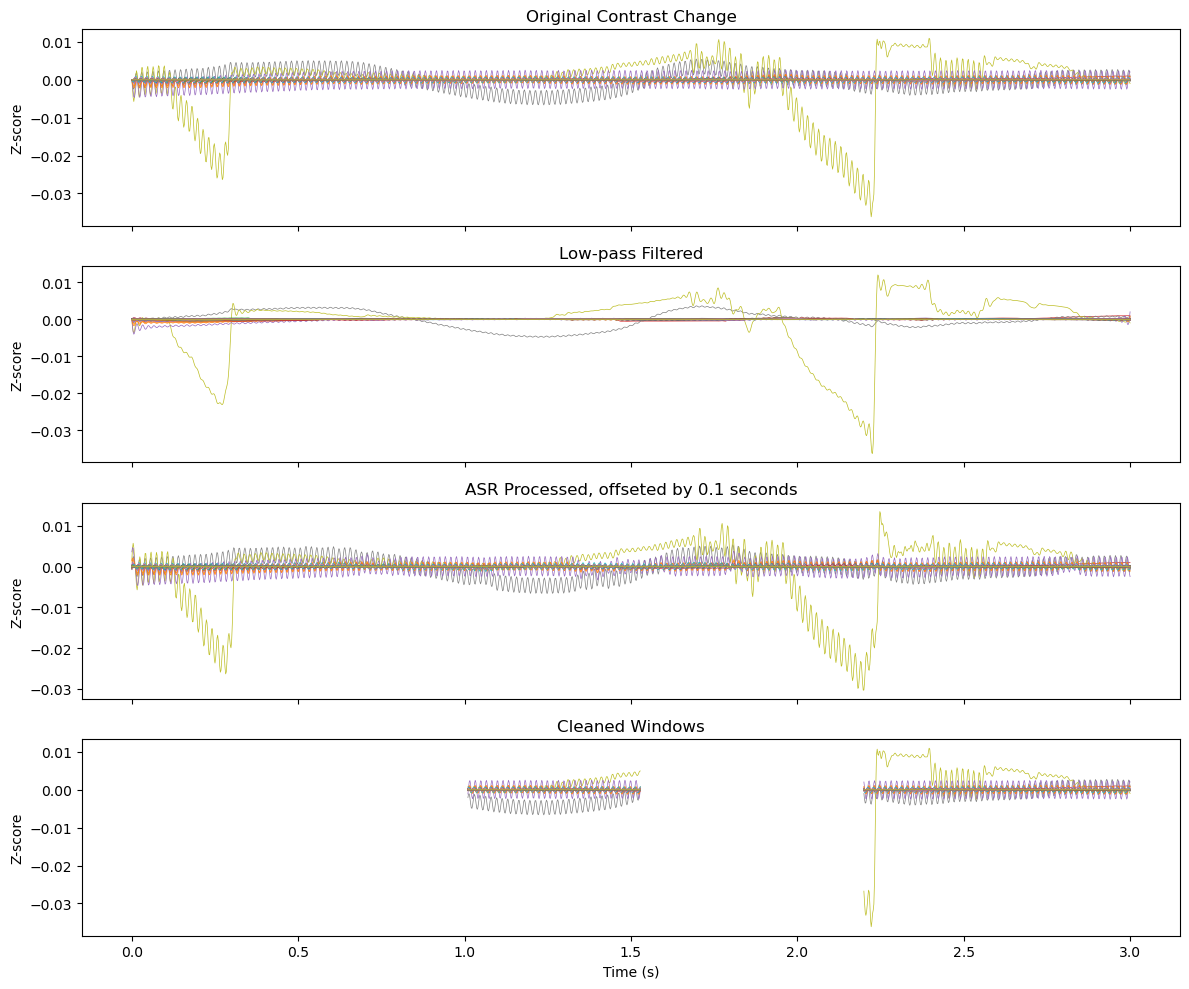

In [137]:
import matplotlib.pyplot as plt
from scipy.stats import zscore

fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

tmin, tmax = 0, 3
for ax, (raw, title) in zip(
    axes,
    [
        (contrast_change_crop, "Original Contrast Change"),
        (low_pass_contrast, "Low-pass Filtered"),
        (asr_contrast_raw, "ASR Processed, offseted by 0.1 seconds"),
        (contrast_cleaned_raw, "Cleaned Windows"),
    ],
):
    data, times = raw.copy().crop(tmin, tmax).get_data(return_times=True)
    ax.plot(times, data.T, lw=0.5)
    ax.set_title(title)
    ax.set_ylabel("Z-score")

axes[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()